# <span style="color:blue">Esercitazione 8</span>

### Esercizio 08.1

Per i primi due esercizi ho scritto la libreria <font face="Courier">VarMC</font>, che implementa metodi Monte Carlo variazionali per la ricerca del *Ground State* di una particella quantistica 1D soggetta al potenziale $V(x)=x^4-\frac{5}{2}x^2$ e per la stima della sua energia di stato fondamentale. Le funzioni di prova usate sono quelle della famiglia

$$ \Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+ e^{-\frac{(x+\mu)^2}{2\sigma^2}} $$

ottenute come la sovrapposizione di due gaussiane di larghezza $\sigma$ e con valor medio in valore assoluto dato da $\mu$. Le funzioni di prova sono tutte pari. La scelta è giustificata dall'analoga parità del potenziale.\
L'obiettivo è quello di trovare per i parametri variazionali la coppia di valori tali che la funzione d'onda così ottimizzata approssimi al meglio il GS. Questo è ottenuto cercando il minimo, nello spazio dei parametri, dell'*energia variazionale* $E_T$, valore di aspettazione dell'Hamiltoniana del sistema sui vari stati di prova:

$$ E_T=\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)} {\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} \equiv
\int dx \ p(x) E_{loc}(x) \ge E_0$$

Terminata l'ottimizzazione sarà la stessa energia di prova a fornire una stima (limite superiore) per l'energia di ground state.

In particolare nel primo esercizio implemento la possibilità di una ricerca del minimo "per tentativi", nel senso che lo script a questo livello è solo in grado di calcolare l'energia variazionale di una particolare funzione di prova. Questo è ottenuto con l'*algoritmo di Metropolis*, la cui probabilità di accettazione è definita in modo tale da riprodurre la distribuzione di probabilità $p(x)=|\Psi_T(x)|^2$: dopo una prima fase di burn-in l'algoritmo arriva a campionare correttamente $p(x)$, e da quel momento mediare con i punti estratti nello spazio reale 1D l'energia locale $E_{loc}$ significa proprio effettuare l'energia variazionale $E_T$. I passi sono effettuati con una probabilità di transizione di prova uniforme la cui larghezza è regolata per avere un'accettazione media attorno al $50\%$.\
La stima di $E_T$ costituirà, nell'esercizio successivo, parte del singolo step dell'algoritmo di *Simulated Annealing* per la ricerca dei parametri ottimizzati.

Per la stima dell'energia di stato fondamentale e della sua incertezza ho, come al solito, utilizzato il blocking method. Qui sotto però riporto solo la fase di burn-in. Preferisco concentrarmi sui risultati solo nel secondo esercizio, dove la ricerca del minimo è resa sistematica.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes    # zoomed up image libraries
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

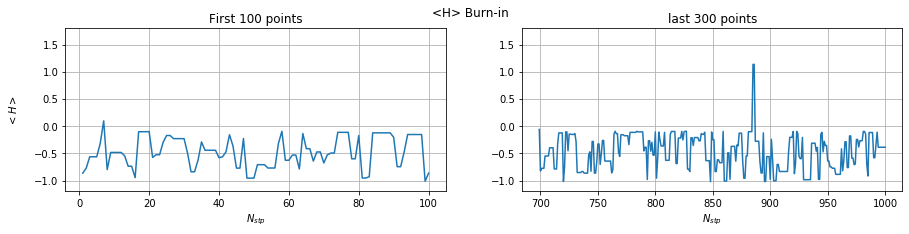

In [2]:
nstep=int(np.genfromtxt('results/trial.0.8_0.62.ene.burn',max_rows=1))
first,last=100,300       #print first 100 and last 300 steps
skip,maxr=(1,nstep-last),(first,nstep)
title=('First '+str(first)+' points','last '+str(last)+' points')

pl.figure(figsize=(15,3))
for i in range(2):
    ene=np.genfromtxt('results/trial.0.8_0.62.ene.burn',skip_header=skip[i],max_rows=maxr[i],names='x,u')
    pl.subplot(1,2,i+1)
    pl.plot(ene['x'],ene['u'])
    pl.ylim(-1.2,1.8)
    pl.xlabel('$N_{stp}$')
    if i==0: pl.ylabel('$<H>$',labelpad=15)
    pl.title(title[i])
    pl.grid(True)
pl.suptitle('<H> Burn-in')
pl.show()

Il grafico rappresenta il sampling istantaneo del valore di aspettazione dell'energia per i primi $100$ e per gli ultimi $300$ punti di una serie da $N_{stp}=10^3$ step. Nel caso di parametri ottimali (qui ho utilizzato $\mu=0.8$ e $\sigma=0.62$, che sono i valori ottimizzati che usciranno dal secondo esercizio) se si parte da $x=0$ il burn-in risulta non necessario, in quanto da subito partiamo in maniera adeguata a campionare la densità di probabilità di GS nella regione di interesse. L'origine sarà sempre scelta nel seguito come posizione di partenza.

### Esercizio 08.2

Nel programma quello che faccio è partire da una coppia di valori di prova iniziali (qui ho scelto $\mu=1$, $\sigma=1$ guardando la forma del potenziale) e cercare il minimo dell'energia variazionale attraverso il metodo del *Simulated Annealing*.

La caratteristica di questo algoritmo è che per il calcolo della probabilità di accettazione si associa al sistema una certa temperatura fittizia $T$ e si utilizza l'algoritmo di Metropolis per campionare (nello spazio dei parametri) dalla corrispondente distribuzione di Boltzmann, considerando come energia del sistema la funzione da minimizzare. Partendo da una temperatura sufficientemente alta (inizialmente tutti gli stati del sistema devono essere esplorabili), raffreddando gradualmente il sistema ed eseguendo ad ogni fase un numero sufficiente alto di step si può lentamente portare il sistema a $T\simeq 0$, condizione nella quale, se il raffreddamento è stato fatto progredire in maniera abbastanza lenta e regolare, la funzione studiata dovrebbe raggiungere il suo minimo, nel senso che, come avviene in generale per un sistema fisico portato lentamente allo zero assoluto, esso non può che esplorare solo configurazioni in un intorno piuttosto ristretto del punto di minimo dell'energia.

In pratica l'algoritmo di Metropolis è usato due volte, una per muovermi nello spazio dei parametri con il Simulated Annealing (classe <font face="Courier">PsiTrial</font>) e un'altra per calcolare, in ognuno dei singoli punti 2D così esplorati, l'energia variazionale relativa ad ognuna delle funzioni d'onda di prova corrispondenti (classe <font face="Courier">VarMC</font>).\
In entrambi i casi mi muovo con un nucleo stocastico uniforme, avendo scelto delle ampiezze tali da mantenere il più possibile un'accettazione media attorno al $50\%$. Questo riesce abbastanza bene nel caso di $\langle \hat{H}_T \rangle$, mentre nello spazio dei parametri l'accettazione cala giustamente ed inevitabilmente sempre di più al diminuire della temperatura simulata (il sistema si assesta sempre più nella regione del minimo).

Per garantire l'efficacia del Simulated Annealing mi è sembarto in questo caso specifico sufficiente partire da $T=10$ (unità in cui $k_B=1$) e arrivare a $T=0.01$ scendendo uniformemente in $\beta=1/T$ con una serie di $20$ raffreddamenti ed eseguendo $200$ step MC ad ogni $T$ corrispondente.\
Ho scelto di salire uniformemente in $\beta$ piuttosto che scendere linearmente in $T$ per avere un'evoluzione delle caratteristiche del sistema il più possibile regolari. Una discesa lineare in $T$ porta infatti a modifiche del sistema sempre più veloci, impendendo un raffreddamento sufficientemente lento perché i risultati forniti dal Simulated Annealing siano corretti. L'aumento uniforme di $\beta$ risolve il problema, come risulta per esempio evidente dalla diminuzione dell'accettazione media $\langle A \rangle$ delle mosse di modifica dei parametri variazionali, che in questo modo rimane pressoché regolare per tutta la simulazione. Come è giusto aspettarsi $\langle A \rangle$ è inizialmente molto vicina ad $1$ (ad alte temperature il sistema può accedere praticamente a qualunque energia), mentre scende a valori sempre più bassi e tende a $0$ per temperature vicine allo zero assoluto (a $T\simeq 0$ il sistema non può che occupare il suo GS).

La discesa, seppur evidente, non è monotona, ma questo si può attribuire ai relativamente pochi passi utilizzati sia per la misura di $<H>$ sia per le mosse nei parametri $\mu$ e $\sigma$. D'altra parte i risultati sono sufficientemente precisi, quindi non ho ritenuto necessario aumentare ulteriormente l'utilizzo delle risorse computazionali al fine di ricercare un risultato maggiormente preciso. Per le stesse ragioni nella fase di raffreddamento ho ritenuto accettabile la presenza di sporadici rate di accettazione intorno al $30\%$ nelle mosse per il calcolo di $<H>$. In questa fase per l'energia non ho utilizzato il blocking method (trascuro qui le incertezze) e ho utilizzato per ogni sua misura singola un numero di step MC pari a $5\times10^3$.

Una volta raggiunta $T=0.01$ ho eseguito la vera e propria misura dei due parametri variazionali, ripetendo le stesse procedure eseguite nella fase di raffreddamento, ma utilizzando inoltre il blocking method (qui $N_{blk}=10$ e per ogni blocco $N_{stp}=10^3$) per la stima con errore di $\mu$ e $\sigma$. Qui l'accettazione è sotto lo $0.1%$. Il valore, molto basso, è (per quello detto in precedenza) proprio la conferma che il processo di raffreddamento ha portato il sistema sufficientemente vicino allo zero assoluto.

A questo punto ho imposto alla funzione d'onda di prova i valori centrali dei parametri ottimizzati, considerati da qui privi di incertezza (nella ricerca non ho messo vincoli di positività; quello che è importante comunque è il modulo dei parametri) e ho quindi eseguito un'accurata analisi MC per determinare il minimo dell'energia variazionale così ottenuta. Qui ho utilizzato il blocking method con $N_{blk}=100$ e $N_{stp}=10^6$ per ogni blocco. I parametri della probabilità di transizione di prova sono ancora tali da avere $\langle A \rangle \simeq 50\%$.

Basandomi sulle considerazioni del primo grafico ad ogni calcolo di $\langle \hat{H} \rangle$ ho eseguito un brevissimo burn-in con solo $N_{burn}=100$.

Il grafico sotto riporta l'andamento della stima di $\langle \hat{H}_T \rangle$ all'aumentare del numero di blocchi utilizzati nel blocking method. I parametri utilizzati per la $\Psi_T(x)$ sono quelli ottenuti con l'ottimizzazione.

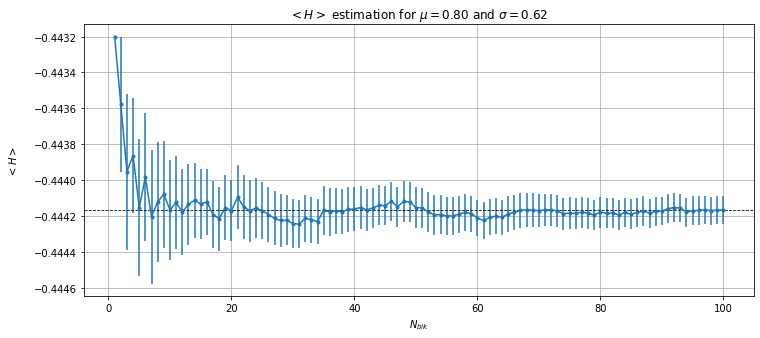

Estimation for mu = 0.800 +- 0.002  and sigma =  0.621 +- 0.002
Result: <H> =  -0.44417 +- 0.00008


In [3]:
ene=np.genfromtxt('results/var.ene.out',usecols=(0,2,3),names='nblk,res,err')
in_mu,in_s,in_H,err_mu,err_s,err_H=np.genfromtxt('results/psiTrial.optimized.out',max_rows=6)

pl.figure(figsize=(12,5))
pl.errorbar(ene['nblk'],ene['res'],yerr=ene['err'],marker='.')
pl.axhline(y=in_H,color='k',linewidth=0.8,linestyle='--')
pl.xlabel('$N_{blk}$')
pl.ylabel('$<H>$',labelpad=15)
pl.grid(True)
pl.title('$<H>$ estimation for $\mu='+format(in_mu,'.2f')+'$ and $\sigma='+format(in_s,'.2f')+'$')
pl.show()

print('Estimation for mu =',format(in_mu,'.3f'),'+-',format(err_mu,'.3f'),' and sigma = ',format(in_s,'.3f'),'+-',format(err_s,'.3f'))
print('Result: <H> = ',format(in_H,'.5f'),'+-',format(err_H,'.5f'))

La linea tratteggiata evidenzia il risultato finale della stima per l'energia di ground state.

Il problema in esame non è risolubile analiticamente in maniera diretta. Quello che si può fare per avere un riferimento teorico è discretizzare lo spazio 1D valutando la funzione d'onda solo su un reticolo di punti posti tra loro a distanze molto ravvicinate. A questo punto la funzione d'onda della particella è un vettore di dimensione pari al numero $N$ di punti del reticolo che si è scelto di considerare all'interno della regione di interesse (qui $x \in [-5,5]$). Nello specchietto sotto viene risolta l'equazione di Schrödinger associata, che a questo punto può essere resa in forma matriciale e corrisponde semplicemente al particolare problema agli autovalori (dell'energia) e agli autovettori (autostati di $\hat{H}$) della matrice

$$ \begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\ \Psi_{2} \\ \vdots \\ \Psi_{N}
\end{bmatrix}
= E \begin{bmatrix}
\Psi_{1} \\ \Psi_{2} \\ \vdots \\ \Psi_{N}
\end{bmatrix} $$

Ground state energy:  -0.4602271303987077


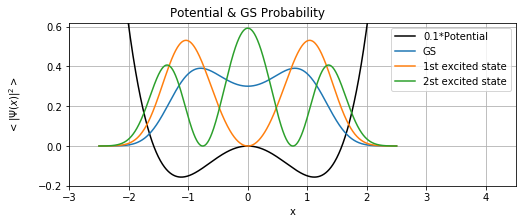

In [4]:
def Vpot(x): return (x**2 - 2.5)*x**2

hbar = 1
m = 1    #mass = 1
Xlim=5.  #x in [-Xlim,Xlim], interval of discretization (it works well for trapping potential)
N = 1000 #number point of the lattice in [-Xlim/2,Xliml/2]

x = np.linspace(-Xlim/2, Xlim/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2
CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)
# Compute eigenvectors and their eigenvalues
E,Psi = np.linalg.eigh(H)
# Take the transpose & normalize (to make graphs)
Psi = np.transpose(Psi)
Psi = Psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
pl.figure(figsize=(8,3))
pl.plot(x, 0.1*V, color="Black", label="0.1*Potential") # plot the potential
pl.plot(x,(Psi[0])**2, label="GS")
pl.plot(x,(Psi[1])**2, label="1st excited state")
pl.plot(x,(Psi[2])**2, label="2st excited state")
pl.legend(loc="best")
pl.title("Potential & GS Probability",x=0.4)
pl.xlabel("x")
pl.ylabel('$<|\Psi(x)|^2>$',labelpad=15)
pl.grid(True)
pl.xlim((-3,4.5))
pl.ylim((-0.2,0.62))
pl.show()

Nel grafico sono rappresentati lo stato fondamentale e i primi due stati eccitati del sistema. Questo sarà utile sia per un confronto con le diverse stime della funzione d'onda di GS ottenute con metodi MC sia per avere un'idea dell'evoluzione delle funzioni d'onda all'aumentare dell'energia, e quindi dell'evoluzione della densità di probabilità della particella all'aumentare della temperatura. Si noti in particolare l'aumento di punti a probabilità nulla, che corrispondono ad un aumento del numero di nodi delle funzioni d'onda. Questo comportamento, unitamente alla simmetria del problema, produrrà un risultato interessante nei grafici a temperatura finita.\
L'energia prevista per il GS è $E_{GS} \simeq -0.46$. Non c'è compatibilità col precedente risultato variazionale, ma questo è sostanzialmente dovuto alla scelta non ottimale della famiglia di funzioni parametriche da ottimizzare.

Segue il grafico della distribuzione di probabilità $|\Psi_T(x)|^2$, la cui misura è stata ottenuta suddividendo l'intervallo di interesse $x \in [-5,5]$ in $100$ bin e costruendo il corrispondente istogramma (normalizzato) delle configurazioni campionate.

In [5]:
def wave_function(irg,plot,mark,lab,ifpot,xrg,yrg,title):
    pl.plot(x,(Psi[0])**2,linewidth=2,label='Schrödinger matricial eqz prediction')
    for i in irg: pl.errorbar(plot[i]['nbin'],plot[i]['res'],yerr=plot[i]['err'],marker=mark[i],label=lab[i])
    if ifpot: pl.plot(psi[0]['nbin'],0.1*Vpot(psi[0]['nbin']),color="Black", label="0.1*Potential")
    pl.legend(loc=4)
    pl.xlabel('$x$')
    pl.ylabel('$<|\Psi(x)|^2>$',labelpad=15)
    pl.xlim(xrg)
    pl.ylim(yrg)
    pl.grid(True)
    pl.title(title)

def zoom(factor,irg,plot,mark,ifpot,xrg,yrg):
    axins=zoomed_inset_axes(ax,factor,loc=3)   # zoomed part, zoom and position
    axins.plot(x,(Psi[0])**2,linewidth=2)
    for i in irg: pl.errorbar(plot[i]['nbin'],plot[i]['res'],yerr=plot[i]['err'],marker=mark[i])
    if ifpot: axins.plot(psi[0]['nbin'],0.1*Vpot(psi[0]['nbin']),color="Black")
    axins.set_xlim(xrg)
    axins.set_ylim(yrg)
    pl.grid(True)
    pl.yticks(visible=False)
    pl.xticks(visible=False)
    mark_inset(ax,axins,loc1=2,loc2=1,fc='none',ec='0.6')

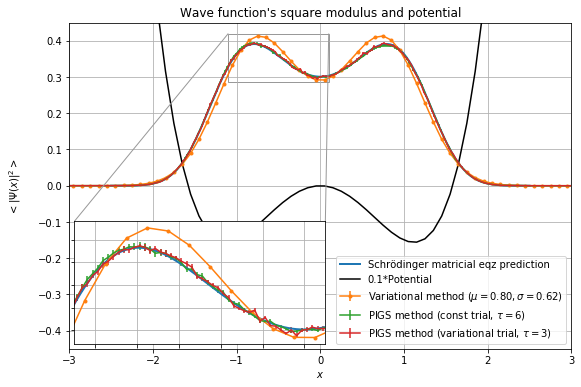

In [6]:
psiVar=np.genfromtxt('results/var.psi.out',skip_header=1,names='nbin,res,err')
psiPIGS=np.genfromtxt('results/probability.const_t6.out',names='nbin,res,err')
psiPIGSvar=np.genfromtxt('results/probability.var_t3.out',names='nbin,res,err')
psi=(psiVar,psiPIGS,psiPIGSvar)
lab1=r'Variational method ($\mu='+format(in_mu,'.2f')+',\sigma='+format(in_s,'.2f')+'$)'
lab2=r'PIGS method (const trial, $\tau=6$)'
lab3=r'PIGS method (variational trial, $\tau=3$)'
lab=(lab1,lab2,lab3); mark=('.','','')

L,binS=np.genfromtxt('results/var.psi.out',max_rows=1)             # Number of throws in each block, bin size
psi[0]['nbin']=binS*(psi[0]['nbin']+1./2.)-Xlim

fig,ax=pl.subplots(figsize=(9,6))
wave_function(range(3),psi,mark,lab,True,(-3.,3.),(-0.45,0.45),"Wave function's square modulus and potential")
zoom(2.5,range(3),psi,mark,True,(-1.1,0.1),(0.285,0.42))
pl.show()

Il risultato variazionale (curva arancione) è confrontato con la previsione teorica ottenuta con l'equazione di Schrödinger in forma matriciale (curva blu) e con le soluzioni numeriche ottenute col metodo PIGS (*Path Integral Ground State*) dell'esercizio successivo. Come anticipato la compatibilità tra il risultato variazionale e quello teorico non è molto buona. D'altra parte quella in arancione è solo la stima migliore della funzione d'onda di GS che si può ottenereall'interno della famiglia di funzioni di prova scelte. Per migliorare il risultato variazionale non si può che cercare una famiglia di funzioni di prova migliori. I risultati ottenuti col PIGS hanno una buona compatibilità

Questo secondo metodo si basa sull'osservazione che evolvere nel tempo immaginario $\tau$ un qualunque stato di prova $| \Psi_T \rangle$ tale che $\langle \Psi_T | \Psi_{GS} \rangle \neq 0$ porta, nel limite $\tau \to \infty$ ed a meno di un fattore di proporzionalità diretta, ad avere l'esatto GS, $| \Psi_T(\tau \to \infty) \rangle \to | \Psi_{GS} \rangle$. Per fare questo dal punto di vista pratico si utilizza l'*approssimazione primitiva*: suddividendo il tempo dell'evoluzione in $M$ sottointervalli sufficientemente piccoli (questi saranno chiamati *timeslices* nel seguito) l'operatore esponenziale di evoluzione risulta semplificato in una forma tale da produrre un'isometria esatta (per $M \to \infty$ l'errore di approssimazione risulta trascurabile rispetto a quello statistico) tra il sistema quantistico studiato (qui la singola particella) ed un sistema classico di polimeri lineari aperti (in numero pari a quello delle particelle del sistema originario) interagenti in un particolare modo adeguatamente definito e costituiti da un numero $M \to \infty$ di particelle classiche, in numero pari a quello delle timeslices, legate tra loro da un potenziale elastico. A questo punto campionare il sistema classico produce direttamente un campionamento esatto del vero (incognito) moto di punto zero del sistema quantistico (da qui la buona compatibilità osservata sopra). Questa operazione viene eseguita sfruttando nuovamente l'algoritmo di Metropolis.\
Nel grafico qui sopra sono riportati i risultati ottenuti partendo da una funzione d'onda $\Psi_T(x)$ costante ('const trial') e da quella ottenuta invece col metodo variazionale ('variational trial'). Chiaramente nel primo caso è necessario evolvere lo stato iniziale per più tempo, in quanto questo è meno somigliante al vero GS rispetto a quello già ottimizzato variazionalmente.

Riporto sotto i vaori misurati coi vari metodi per l'energia di ground state.

In [7]:
PIGS=[0 for i in range(4)]; obs=['potential','kinetic']; tau=['const_t6','var_t3']; tt=(6,3); tslice=(240,120)
for i in range(2):
    for j in range(2):
        PIGS[2*i+j]=np.genfromtxt('results/'+obs[i]+'.'+tau[j]+'.out',names='time,res,err')

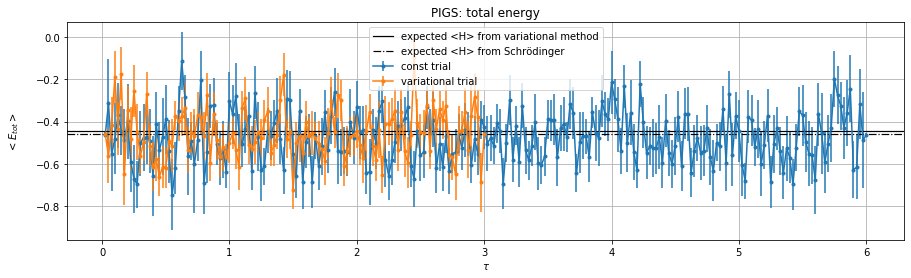

In [8]:
trial_type=("const trial","variational trial")
ene,err=[0,0],[0,0]
for i in range(2):
    ene[i]=PIGS[i]['res']+PIGS[i+2]['res']
    err[i]=np.sqrt(PIGS[i]['err']**2+PIGS[i+2]['err']**2)
    
fig,ax=pl.subplots(figsize=(15,4))
for i in range(2): pl.errorbar((PIGS[i]['time']+1)/tslice[i]*tt[i],ene[i],yerr=err[i],marker='.',label=trial_type[i])
pl.axhline(y=in_H,color='k',linewidth=1.2,label='expected <H> from variational method')
#pl.axhline(y=in_H+err_H,color='k',linewidth=1.2)   #not seen
#pl.axhline(y=in_H-err_H,color='k',linewidth=1.2)   #not seen
pl.axhline(y=E[0],color='k',linewidth=1.2,linestyle='-.',label='expected <H> from Schrödinger')
pl.legend(loc='best')
pl.xlabel(r'$\tau$')
pl.ylabel(r'$<E_{tot}>$',labelpad=15)
pl.grid(True)
pl.title("PIGS: total energy")
pl.show()

I valori istantanei dell'energia totale del metodo PIGS oscillano correttamente attorno ai valori previsti dalgi altri due metodi.

Se ci si concentra sulla sola energia potenziale la situazione è giustamente diversa.

In [9]:
def img_evol(plot,howMany,xline,color):
    fig,ax=pl.subplots(figsize=(15,3))
    for i in range(2):
        pl.subplot(1,2,i+1)
        for j in range(howMany):
            pl.errorbar(plot[i+2*j]['time'],plot[i+2*j]['res'],yerr=plot[i+2*j]['err'])
            for k in [2*i+4*j,2*i+4*j+1]: pl.axvline(x=xline[k],color=color[j],linewidth=1.2,linestyle='--')
        pl.xlabel(r'timeslice')
        if i==0: pl.ylabel('$<E_{pot}>$',labelpad=15)
        pl.grid(True)
        pl.title(trial_type[i])
    pl.suptitle("PIGS: potential energy")
    pl.show()

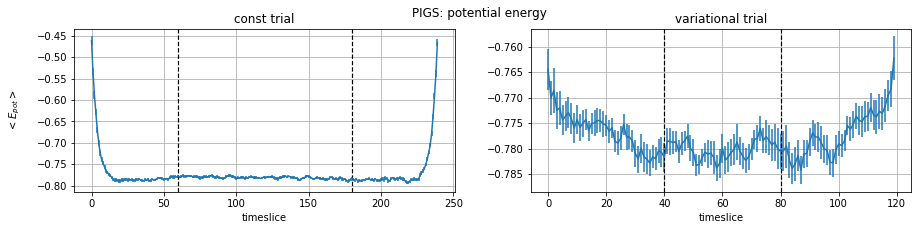

In [10]:
img_evol(PIGS,1,(60,180,40,80),'k')

Il grafici mostrano come l'intervallo di timeslice scelto nei due casi per le analisi sia adatto a studiare le proprietà di GS: tra le linee tratteggiate ho un valore di energia potenziale statisticamente costante, e questo indica che sono in un intervallo di tempi immaginari tali da stare campionando il moto di punto zero del GS. Infatti quello che viene riportato nel grafico è la stima del valore di aspettazione $\langle \Psi(\tau)|\hat{V}|\Psi(\tau_{max}-\tau)\rangle$, dove $\tau$ è il tempo immaginario corrispondente alla timeslice considerato. $\tau_{max}$ quello totale di evoluzione. Avvicinandosi agli estremi dell'evoluzione temporale uno dei due stati (il bra o il ket) diventa sempre più simile a quello di prova iniziale e assomigliano sempre meno al GS. Per studiare le proprietà dello stato fondamentale bisogna considerare solo le timeslice sufficientemente centrali rispetto all'intera evoluzione nel tempo immaginario. Qui la stabilità statistica del valore di aspettazione $\langle E_{pot} \rangle$ assicura di essere in una regione in cui entrambi gli stati sono sufficientemente evoluti.\
Nel caso variazionale mi sono potuto permettere di usare mano timeslice: $\tau$ è dimezzato, e quindi anche il numero di sottointervalli può essere ridotto alla metà senza pregiudicare la validità dell'approssimazione primitiva, ma facendo comunque guadagnare tempo computazionale (lo stesso discorso varrà per l'algoritmo PIMC con l'aumento della temperatura, che corrisponde ad una diminuzione di $\beta$).

### Esercizio 08.3

Come anticipato, nell'ultimo esercizio utilizzo i metodi PIGS e PIMC (*Path Integral Monte Carlo*, tecnica analoga al PIGS, ma qui l'approssimazione primitiva si applica all'esponenziale di Boltzmann per lo studio a temperatura finita) per studiare rispettivamente il GS e le proprietà a $T>0$ della singola particella quantistica nel potenziale $V(x)$.

Come prima cosa ho quindi utilizzato il metodo PIGS partendo da una funzione di prova costante ('const trial') e da quella ottenuta col metodo variazionale ('var trial'). Di seguito i risultati.

In [11]:
psiPIGS=[0 for i in range(7)]
psiT=['const' for i in range(3)]+['var' for i in range(4)]
tau=['6','5','3','3','2','1','05']
for i in range(len(psiPIGS)):
    psiPIGS[i]=np.genfromtxt('results/probability.'+psiT[i]+'_t'+tau[i]+'.out',names='nbin,res,err')

lab=('const trial','variational trial')

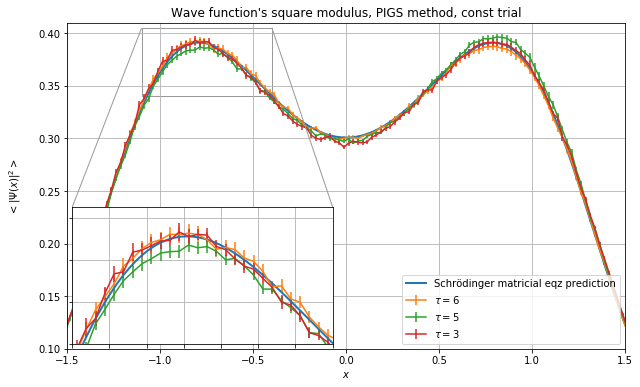

In [12]:
tau=['6','5','3','3','2','1','05']
fig,ax=pl.subplots(figsize=(10,6)); mark=['' for i in range(3)]; irg=range(3)
wave_function(irg,psiPIGS,mark,[r'$\tau='+tau[i]+'$' for i in irg],False,(-1.5,1.5),(0.1,0.41),"Wave function's square modulus, PIGS method, const trial")
zoom(2,range(3),psiPIGS,mark,False,(-1.1,-0.4),(0.34,0.405))
pl.show()

Nel primo caso serve evolvere la trial costante per un tempo $\tau \sim 6$ per avere una buona compatibilità col risultato teorico. La funzione d'onda costante di partenza è troppo differente da quella di GS perché evoluzioni più brevi diano risultati affidabili.

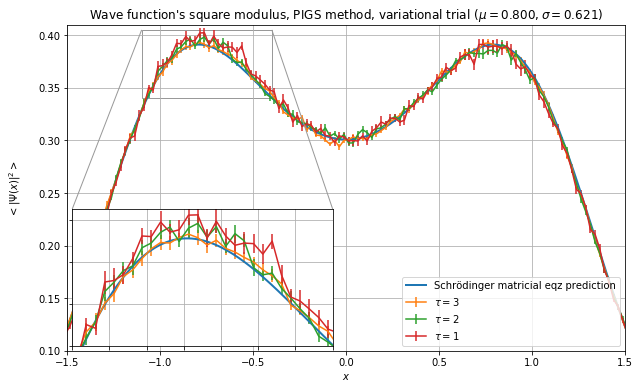

In [13]:
tau=['6','5','3','3','2','1','05']
fig,ax=pl.subplots(figsize=(10,6)); mark=['' for i in range(3)]; irg=range(3,6)
wave_function(irg,psiPIGS,mark*2,[r'$\tau='+tau[i]+'$' for i in range(6)],False,(-1.5,1.5),(0.1,0.41),"Wave function's square modulus, PIGS method, variational trial ($\mu="+format(in_mu,'.3f')+",\sigma="+format(in_s,'.3f')+"$)")
zoom(2,irg,psiPIGS,mark*2,False,(-1.1,-0.4),(0.34,0.405))
pl.show()

La trial variazionale è invece già più vicina al vero GS, e questo permette di ridurre il tempo di propagazione circa della metà rispetto al caso precedente.

Subito sotto verifico che la scelta delle timeslice utilizzate per il calcolo dei risultati nei vari casi sono tutte sensate, e cioè che in tutti i casi sto considerando la regione in cui campiono il GS.

In [14]:
newPIGS=[0 for i in range(4)]
psiT=['const','var']*2
tau=['5','2','3','1']
for i in range(len(newPIGS)):
        newPIGS[i]=np.genfromtxt('results/potential.'+psiT[i]+'_t'+tau[i]+'.out',names='time,res,err')

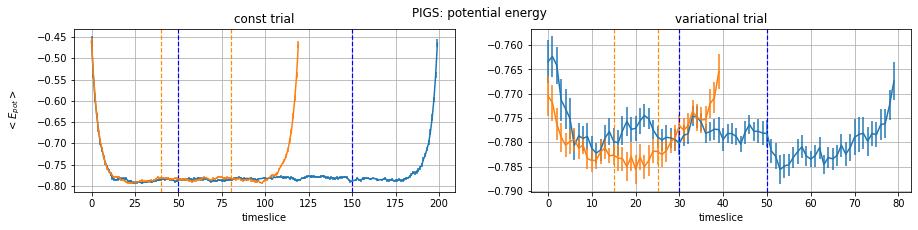

In [15]:
img_evol(newPIGS,2,(50,150,30,50,40,80,15,25),('b','darkorange'))

Rispettivamente nei due casi 'const' e 'var' le curve blu sono relative alle evoluzioni per $\tau=5$ e $\tau=2$, mentre quelle arancioni per $\tau=3$ e $\tau=1$. L'andamento di $\langle E_{pot} \rangle$ negli ultimi due casi sono già stati riportati e commentati nel corso dell'esercizio precedente. Anche qui nella regione analizzata, individuata dalle linee tratteggiate verticali, i valori di energia potenziali misurati sono statisticamente costanti.

Se non avessimo la possibilità di confronto con la soluzione matriciale potremmo basarci su questi grafici per capire qual è il minimo tempo per cui dobbiamo proiettare la funzione di prova, nel senso che dobbiamo sempre avere un plateau significativo su cui poter andare a misurare la distribuzione di probabilità. Nel caso 'var trial' questa operazione è un po' più difficile perchè siamo già vicini al GS, e in parte diventa complicato capire cosa è oscillazione statistica e cosa è convergenza verso la dinamica di punto zero.

Studio infine l'andamento dell'ampiezza di probabilità per la posizione della particella al crescere della temperatura $T$ col metodo PIMC.

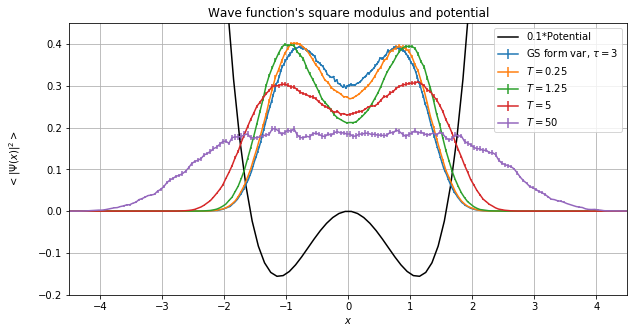

In [16]:
psiPIMC_0_25=np.genfromtxt('results/probability.T0_25.out',names='nbin,res,err')
psiPIMC_1_25=np.genfromtxt('results/probability.T1_25.out',names='nbin,res,err')
psiPIMC_5=np.genfromtxt('results/probability.T5.out',names='nbin,res,err')
psiPIMC_50=np.genfromtxt('results/probability.T50.out',names='nbin,res,err')
PIMC=(psiPIMC_0_25,psiPIMC_1_25,psiPIMC_5,psiPIMC_50)

fig,ax=pl.subplots(figsize=(10,5)); label=('0.25','1.25','5','50')
pl.errorbar(psiPIGS[3]['nbin'],psiPIGS[3]['res'],yerr=psiPIGS[3]['err'],label=r'GS form var, $\tau=3$')
for i in range(4): pl.errorbar(PIMC[i]['nbin'],PIMC[i]['res'],yerr=PIMC[i]['err'],label=r'$T='+label[i]+'$')
pl.plot(psi[0]['nbin'],0.1*Vpot(psi[0]['nbin']),color="Black", label="0.1*Potential")
pl.legend(loc='best')
pl.xlabel('$x$')
pl.ylabel('$<|\Psi(x)|^2>$',labelpad=15)
pl.xlim(-4.5,4.5)
pl.ylim(-0.2,0.45)
pl.grid(True)
pl.title("Wave function's square modulus and potential")
pl.show()

A energie sempre maggiori la particella può esplorare sempre più facilmente zone a potenziale più alto. Per questa ragione all'aumentare della temperatura la distribuzione di probabilità tende ad espandersi, e sempre per questo il massimo locale nell'intorno dell'origine tende in qualche modo a diventare trascurabile, tanto che ad energie sufficientemente alte (si veda $T=50$) $\langle |\Psi(x)|^2 \rangle$ diventa pressochè costante nella regione centrale.

E' però interessante notare come quest'ultimo comportamento sia inizialmente disatteso per piccole $T$, per le quali aumentare l'energia porta ad un incremento della differenza tra le probabilità relative di trovare la particella nell'intorno dell'origine o di quello dei minimi locali. La ragione va ricercata nella parità del potenziale, e quindi delle autofunzioni, e nel fatto che queste hanno un numero di nodi pari al livello eccitato a cui sono associate ($\Psi_GS(x)$ è l'unica ad essere non nulla su tutto l'asse reale; si veda per i primi stati il grafico sotto le soluzioni dell'equazione di Schrödinger in forma matriciale). A temperatura finita il sistema viene inevitabilmente preparato in uno stato miscela, in cui si ha una serie di probabilità di trovare la particella in uno dei possibili autostati. Nella prima fase di aumento della temperatura cresce in particolare la probabilità che la particella si trovi nel primo stato eccitato, e per le proprietà della autofunzioni appena descritte questa deve annullarsi nell'origine. La sovrapposizione tra GS e primo eccitato porta così ad una iniziale diminuzione della probabilità di trovare la particella in $x=0$ e ad un conseguente incremento relativo dei dui massimi di $\langle |\Psi(x)|^2 \rangle$. All'aumentare ulteriore della temperatura sempre più stati diventano disponibili, e la loro combinazione multipla porta invece ad una distribuzione di probabilità che tende ad essere sempre più estesa e costante, grazie al fatto che gli stati eccitati pari vanno a compensare con un massimo locale l'annullamento nell'origine delle funzioni d'onda degli stati eccitati dispari.

Concludo con una nota sulla probabilità di accettazione media $\langle A \rangle$ nei PIGS e PIMC. Come già accennato, questi metodi sfruttano ancora l'algoritmo di Metropolis, e quindi si cerca come sempre di regolare l'accettazione di tutte le mosse MC attorno al $50\%$. Quelle principali sono la traslazione rigida del polimero (aperto per il PIGS, chiuso per il PIMC) e quelle browniane, *Brownian Bridge* e (solo per il PIGS) *Brownian Motion*, nelle quali vengono eliminate e ricostruite rispettivamente le code o la parte centrale della catena. La ricostruzione viene eseguita campionando in maniera esatta la parte cinetica, gaussiana, della matrice densità, mentre l'accettazione è abbassata in pratica solo dalla parte di energia potenziale. In pratica stiamo qui unendo algoritmo di Metropolis ed importance sampling (la probabilità di transizione di prova è adattata al problema considerato), e questo rende le mosse browniane molto efficienti e caratterizzate spesso da un'accettazione che sale anche oltre il $90\%$. In effetti questa può essere ridotta solo fino a un certo punto aumentando il numero di atomi da ricostruire (può lunga è la parte di polimero cancella può è probabile di raggiungere zone rese proibitive dall'aumento del potenziale), nel senso che comunque non si possono cancellare più atomi di quelli che costituiscono l'intera catena. Questo porta spesso a valori di $\langle A \rangle$ molto alti, motivati comunque dall'utilizzo dell'importance sampling.\
Nel caso delle traslazioni rigide $\langle A \rangle$ è invece del tutto controllabile, grazie soprattutto al fatto di avere un potenziale vincolante che impedisce spostamenti troppo grandi.